In [1]:
import logging
import ast
from datasets import load_dataset
%load_ext autoreload
%autoreload 2
from chatsky_llm_autoconfig.settings import EnvSettings
from chatsky_llm_autoconfig.algorithms.three_stages_1 import ThreeStagesGraphGenerator
from chatsky_llm_autoconfig.dialogue import Dialogue
from chatsky_llm_autoconfig.graph import Graph
from chatsky_llm_autoconfig.algorithms.dialogue_generation import RecursiveDialogueSampler
from chatsky_llm_autoconfig.metrics.automatic_metrics import all_utterances_present

/home/peshkichev/miniconda3/envs/py11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [2]:
logging.getLogger("langchain_core.vectorstores.base").setLevel(logging.ERROR)
env_settings = EnvSettings()

In [3]:
graph_generator = ThreeStagesGraphGenerator()
dialogue_sampler = RecursiveDialogueSampler()

In [4]:
def add_dialogues(graph: Graph, dialogues: list[Dialogue]):
     if graph:
         sampled_dialogues = dialogue_sampler.invoke(graph, 15)
         data = (sampled_dialogues+dialogues).copy()
     else:
          data = dialogues
     return graph_generator.invoke(data)


## MULTIWOZ2_2

In [5]:
dataset = load_dataset('Salesforce/dialogstudio', 'MULTIWOZ2_2', token=env_settings.HUGGINGFACE_TOKEN, trust_remote_code=True)

Using the latest cached version of the module from /home/peshkichev/.cache/huggingface/modules/datasets_modules/datasets/Salesforce--dialogstudio/5778b28eb3729807803ab09b88c9f4dfcd41134879e168fdcccd16d3d5559da7 (last modified on Tue Feb 18 07:54:50 2025) since it couldn't be found locally at Salesforce/dialogstudio, or remotely on the Hugging Face Hub.


In [4]:
dataset['test'][0]

{'original dialog id': 'PMUL3520.json',
 'new dialog id': 'MULTIWOZ2_2--test--1',
 'dialog index': 1,
 'original dialog info': '{"services": ["restaurant", "train"]}',
 'log': [{'turn id': 1,
   'user utterance': 'I need a train going to Cambridge that will depart after 10:15 from broxbourne.',
   'system response': 'I have train TR5678 that would suit you.',
   'dialog history': '',
   'original user side information': '{"frames": [{"actions": [], "service": "train", "slots": [{"exclusive_end": 62, "slot": "train-leaveat", "start": 57, "value": "10:15"}], "state": {"active_intent": "find_train", "requested_slots": [], "slot_values": {"train-departure": ["broxbourne"], "train-destination": ["cambridge"], "train-leaveat": ["10:15"]}}}, {"actions": [], "service": "taxi", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"actions": [], "service": "bus", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"

### Restaurant dialogues

In [6]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["restaurant"]]

In [77]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["restaurant", "train"]]

In [6]:
data = [d for d in dataset['test'] if ast.literal_eval(d['original dialog info'])["services"]==["train"]]

In [29]:
data[0]

{'original dialog id': 'SNG0661.json',
 'new dialog id': 'MULTIWOZ2_2--test--6',
 'dialog index': 6,
 'original dialog info': '{"services": ["restaurant"]}',
 'log': [{'turn id': 1,
   'user utterance': "I'm looking for an Indian restaurant, preferably in the centre of town.",
   'system response': 'There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'dialog history': '',
   'original user side information': '{"frames": [{"actions": [], "service": "restaurant", "slots": [{"exclusive_end": 25, "slot": "restaurant-food", "start": 19, "value": "Indian"}], "state": {"active_intent": "find_restaurant", "requested_slots": [], "slot_values": {"restaurant-area": ["centre"], "restaurant-food": ["indian"]}}}, {"actions": [], "service": "taxi", "slots": [], "state": {"active_intent": "NONE", "requested_slots": [], "slot_values": {}}}, {"actions": [], "service": "train", "slots": [], "state": {"active_intent": "NONE", "requested_slots":

In [30]:
len(data)

65

In [7]:
new_data=[]
for d in data:
    exist = [[{"text":u['user utterance'],"participant":"user"},{"text":u['system response'],"participant":"assistant"}] for u in d['log']]
    new_data.append([{"text":"Hello! How can I help you?","participant":"assistant"}] + [x for xs in exist for x in xs])

#### 1 dialogue

In [8]:
test_data = [Dialogue.from_list(c) for c in new_data[:1]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/algorithms/three_stages_1.py:76: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=env_settings.EMBEDDER_MODEL, model_kwargs={"device": env_settings.EMBEDDER_DEVICE})
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']}, {'id': 5, 'label': 'end', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!']}], 'reason': ''}


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]}, {'source': 2, 'target': 3, 'utterances': ['I would prefer cheap restaurants.']}, {'source': 3, 'target': 4, 'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']}, {'source': 4, 'target': 5, 'utterances': ["No that's all I needed. Thank you!"]}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your

True

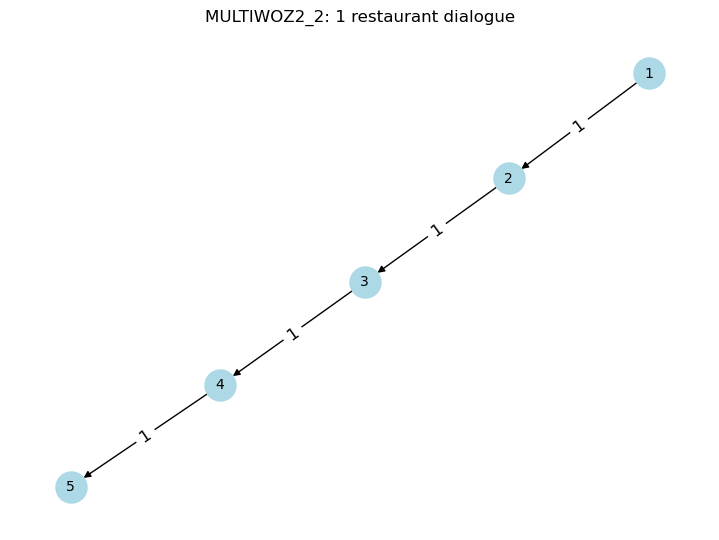

In [9]:
graph.visualise_short("MULTIWOZ2_2: 1 restaurant dialogue")

In [10]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'provide_options',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'confirm_booking',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'end',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!']}]

In [11]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!"]}]

#### 2 dialogues

In [37]:
new_data[:2]

[[{'text': 'Hello! How can I help you?', 'participant': 'assistant'},
  {'text': "I'm looking for an Indian restaurant, preferably in the centre of town.",
   'participant': 'user'},
  {'text': 'There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'participant': 'assistant'},
  {'text': 'I would prefer cheap restaurants.', 'participant': 'user'},
  {'text': 'I was able to find three options in your price range, may I recommend The Gandhi?',
   'participant': 'assistant'},
  {'text': 'Sure please book a table there fore 7 people at 12:15 on saturday',
   'participant': 'user'},
  {'text': 'I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'participant': 'assistant'},
  {'text': "No that's all I needed. Thank you!", 'participant': 'user'},
  {'text': 'Thank you for calling, enjoy!', 'participant': 'assistant'}],
 [{'t

In [8]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/algorithms/three_stages_1.py:76: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=env_settings.EMBEDDER_MODEL, model_kwargs={"device": env_settings.EMBEDDER_DEVICE})
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_indian_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_gandhi', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'booking_confirmation', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?', 'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']}, {'id': 5, 'label': 'closing', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!', "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day."]}, {'id': 6, 'label':

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]}, {'source': 2, 'target': 3, 'utterances': ['I would prefer cheap restaurants.']}, {'source': 3, 'target': 4, 'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']}, {'source': 1, 'target': 6, 'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']}, {'source': 4, 'target': 5, 'utterances': ["No that's all I needed. Thank you!", 'Thanks for you help. I only need the restaurant reservation. Goodbye.']}, {'source': 6, 'target': 7, 'utterances': ['The restaurant should serve italian food.']}, {'source': 7, 'target': 8, 'utterances': ['What other restaurants in that area serve Italian food?']}, {'source': 8, 'target': 9, 'utterances': ['No, that will do. Can I book a table for monday?']}, {'source': 9, 'target': 4, 'utterances': ['I will have 5 people and

False

In [35]:
res=  {'edges': [{'source': 1, 'target': 2, 'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]}, {'source': 2, 'target': 3, 'utterances': ['I would prefer cheap restaurants.']}, {'source': 3, 'target': 4, 'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']}, {'source': 1, 'target': 3, 'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']}, {'source': 3, 'target': 7, 'utterances': ['The restaurant should serve italian food.']}, {'source': 4, 'target': 5, 'utterances': ["No that's all I needed. Thank you!", 'Thanks for you help. I only need the restaurant reservation. Goodbye.']}, {'source': 6, 'target': 7, 'utterances': ['The restaurant should serve italian food.']}, {'source': 7, 'target': 8, 'utterances': ['What other restaurants in that area serve Italian food?']}, {'source': 8, 'target': 9, 'utterances': ['No, that will do. Can I book a table for monday?']}, {'source': 9, 'target': 4, 'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range_indian', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_indian_option', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?', 'Try curry prince or pizza hut fen ditton']}, {'id': 4, 'label': 'confirmation_and_reference', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?', 'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']}, {'id': 5, 'label': 'closing', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!', "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day."]}, {'id': 6, 'label': 'recommend_moderate_east', 'is_start': False, 'utterances': ['Try curry prince or pizza hut fen ditton']}, {'id': 7, 'label': 'ask_reservation', 'is_start': False, 'utterances': ['Pizza hut fen ditton serves italian food in the east, would you like a reservation?']}, {'id': 8, 'label': 'offer_other_areas', 'is_start': False, 'utterances': ['Pizza hut fen ditton is the only Italian restaurant, in the east, in the moderate price range. Do you want me to try other areas?']}, {'id': 9, 'label': 'ask_reservation_details', 'is_start': False, 'utterances': ['Absolutely, how many people will you have and what time are you wanting the reservation?']}]} 


In [36]:
res['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 1,
  'target': 3,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 3,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!",
   'Thanks for you help. I only need the restaurant reservation. Goodbye.']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No,

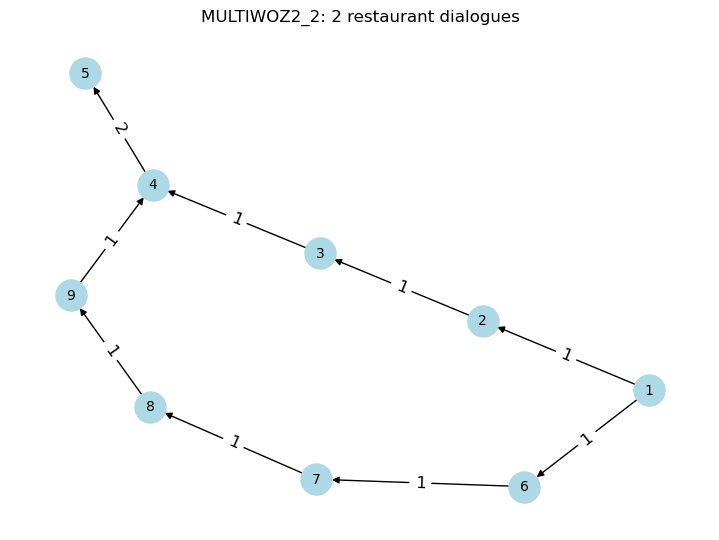

In [9]:
graph.visualise_short("MULTIWOZ2_2: 2 restaurant dialogues")

In [10]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'provide_indian_options',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_gandhi',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'booking_confirmation',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']},
 {'id': 5,
  'label': 'closing',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!',
   "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day."

In [11]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!",
   'Thanks for you help. I only need the restaurant reservation. Goodbye.']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 4,
  'utterances'

#### 3 dialogues

In [20]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range_indian', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_gandhi', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'booking_confirmation', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?', 'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']}, {'id': 5, 'label': 'farewell', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!', 'Thank you. Have a nice day.', "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a g

False

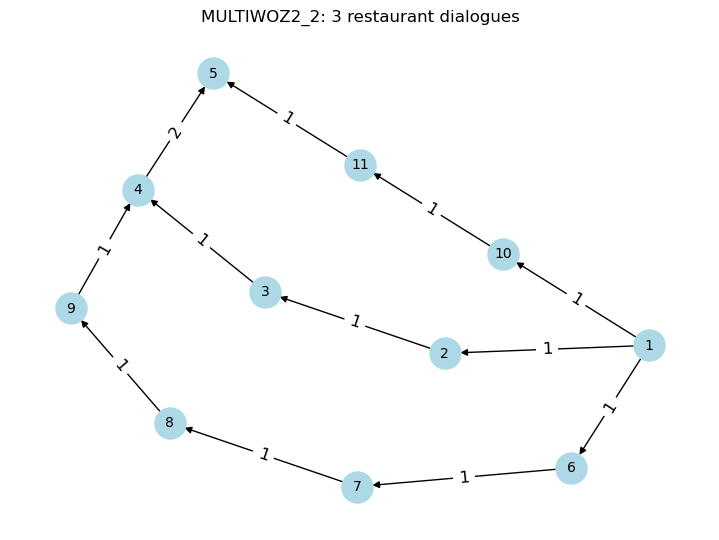

In [21]:
graph.visualise_short("MULTIWOZ2_2: 3 restaurant dialogues")

In [22]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_price_range_indian',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_gandhi',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'booking_confirmation',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?']},
 {'id': 5,
  'label': 'farewell',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!',
   'Thank you. Have a nice day.',
   "You're welcome. Thank you for contacting Cambridge Town

In [23]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 4,
  'target': 5,
  'utterances': ["No that's all I needed. Thank you!",
   'Thanks for you help. I only need the restaurant reservation. Goodbye.']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 4,
  'utterances'

### 4 dialogues

In [124]:
new_data[:4]

[[{'text': 'Hello! How can I help you?', 'participant': 'assistant'},
  {'text': "I'm looking for an Indian restaurant, preferably in the centre of town.",
   'participant': 'user'},
  {'text': 'There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'participant': 'assistant'},
  {'text': 'I would prefer cheap restaurants.', 'participant': 'user'},
  {'text': 'I was able to find three options in your price range, may I recommend The Gandhi?',
   'participant': 'assistant'},
  {'text': 'Sure please book a table there fore 7 people at 12:15 on saturday',
   'participant': 'user'},
  {'text': 'I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'participant': 'assistant'},
  {'text': "No that's all I needed. Thank you!", 'participant': 'user'},
  {'text': 'Thank you for calling, enjoy!', 'participant': 'assistant'}],
 [{'t

In [141]:
test_data = [Dialogue.from_list(c) for c in new_data[:4]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?', 'I found five expensive restaurants on the south side of town. Would you prefer Chinese, Indian, Italian or Mexican?', 'I have found many possibilities. Golden house is chinese and the river bar steakhouse and grill serves modern european. Are either of those of interest for you?', 'Try curry prince or pizza hut fen ditton']}, {'id': 3, 'label': 'provide_recommendation', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?', 'Pizza hut fen ditton serves italian food in the east, would you like a reservation?', 'Pizza hut fen ditton is the only Italian restaurant, in the east, in the moderate price range. Do you want me to try other 

False

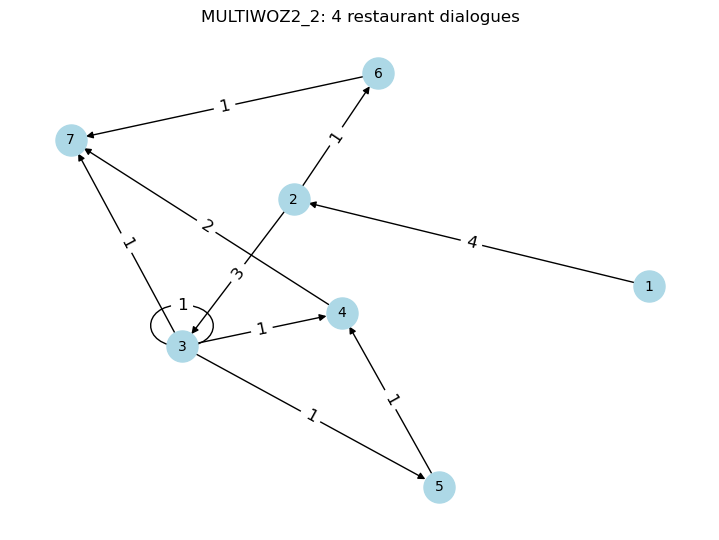

In [142]:
graph.visualise_short("MULTIWOZ2_2: 4 restaurant dialogues")

In [143]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'provide_options',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'I found five expensive restaurants on the south side of town. Would you prefer Chinese, Indian, Italian or Mexican?',
   'I have found many possibilities. Golden house is chinese and the river bar steakhouse and grill serves modern european. Are either of those of interest for you?',
   'Try curry prince or pizza hut fen ditton']},
 {'id': 3,
  'label': 'provide_recommendation',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?',
   'Pizza hut fen ditton serves italian food in the east, would you like a reservation?',
   'Pizza hut fen ditton is the only Italian restaurant, in the east, in the moderate price range. Do you want

In [145]:
graph.graph_dict['edges']

[{'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 3,
  'target': 3,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 3,
  'target': 5,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 4,
  'target': 7,
  'utterances': ["No that's all I needed. Thank you!",
   'Thanks for you help. I only need the restaurant reservation. Goodbye.']},
 {'source': 5,
  'target': 4,
  'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.',
   'The restaurant should serve italian food.',
   'Do you have a favorite you could recommend? I will need the phone and postcode and food type also please.']},
 {'source': 3,
  'target': 7,
  'utterances': ['No, that will be it. Thank you for your help.']},
 {'source': 1,
  'target': 2,
  'utterances': ["

#### 5 dialogues

In [8]:
new_data[:5]

[[{'text': 'Hello! How can I help you?', 'participant': 'assistant'},
  {'text': "I'm looking for an Indian restaurant, preferably in the centre of town.",
   'participant': 'user'},
  {'text': 'There are a number of options for Indian restaurants in the centre of town. What price range would you like?',
   'participant': 'assistant'},
  {'text': 'I would prefer cheap restaurants.', 'participant': 'user'},
  {'text': 'I was able to find three options in your price range, may I recommend The Gandhi?',
   'participant': 'assistant'},
  {'text': 'Sure please book a table there fore 7 people at 12:15 on saturday',
   'participant': 'user'},
  {'text': 'I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'participant': 'assistant'},
  {'text': "No that's all I needed. Thank you!", 'participant': 'user'},
  {'text': 'Thank you for calling, enjoy!', 'participant': 'assistant'}],
 [{'t

In [134]:
test_data = [Dialogue.from_list(c) for c in new_data[:5]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_price_range_indian', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_restaurant', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'reservation_confirmation', 'is_start': False, 'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?', 'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?', 'Your table is reserved at 13:00 on Friday. Your reference number is RQ2L5TKR .']}, {'id': 5, 'label': 'end_thank_you', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!', "You're welcome. 

False

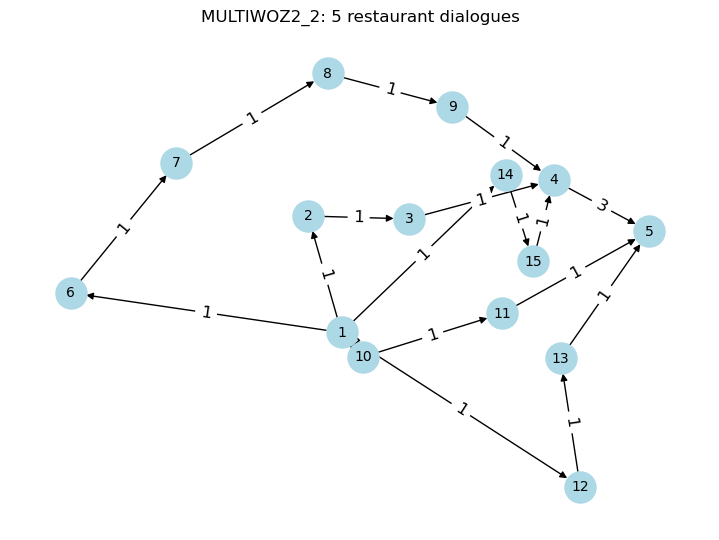

In [135]:
graph.visualise_short("MULTIWOZ2_2: 5 restaurant dialogues")

In [136]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_price_range_indian',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'reservation_confirmation',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?',
   'You are booked, the reference number is AF2GJ7G6, may I assist with anything else?',
   'Your table is reserved at 13:00 on Friday. Your reference number is RQ2L5TKR .']},
 {'id': 5,
  'label': 'end_thank_you',
  'is_start': False,
  'utterances': ['Thank you for calling, enjo

In [137]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ["I'm looking for an Indian restaurant, preferably in the centre of town."]},
 {'source': 2,
  'target': 3,
  'utterances': ['I would prefer cheap restaurants.']},
 {'source': 3,
  'target': 4,
  'utterances': ['Sure please book a table there fore 7 people at 12:15 on saturday']},
 {'source': 1,
  'target': 6,
  'utterances': ['I am looking for a restaurant. The restaurant should be in the moderate price range and should be in the east']},
 {'source': 6,
  'target': 7,
  'utterances': ['The restaurant should serve italian food.']},
 {'source': 7,
  'target': 8,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 8,
  'target': 9,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 9,
  'target': 4,
  'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']},
 {'source': 1,
  'target': 10,
  'utterances': ["I'm looking for a place to dine on the s

#### 6 restaurant dialogues

In [138]:
test_data = [Dialogue.from_list(c) for c in new_data[:6]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_indian_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']}, {'id': 3, 'label': 'recommend_the_gandhi', 'is_start': False, 'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']}, {'id': 4, 'label': 'confirm_booking_with_reference', 'is_start': False, 'utterances': ['I was able to book that for you. They will reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']}, {'id': 5, 'label': 'farewell_calling', 'is_start': False, 'utterances': ['Thank you for calling, enjoy!']}, {'id': 6, 'label': 'suggest_curry_prince_or_pizza_hut', 'is_start': False, 'utterances': ['Try curry prince or pizza hut fen ditton']}, {'id': 7, 'label': 'ask_reservation_pizza

False

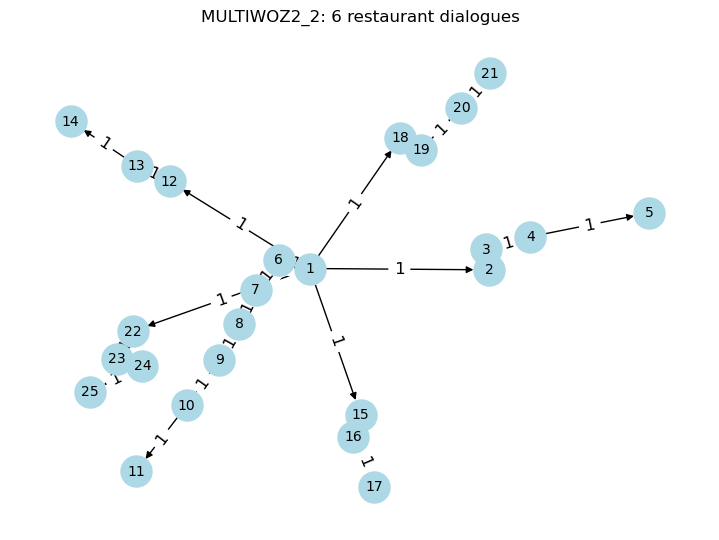

In [139]:
graph.visualise_short("MULTIWOZ2_2: 6 restaurant dialogues")

In [140]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'provide_indian_options',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_the_gandhi',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'confirm_booking_with_reference',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'farewell_calling',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!']},
 {'id': 6,
  'label': 'suggest_curry_prince_or_pizza_hut',
  'is_start': False,
  'utterances': ['Try curry prince or pizza hut fen ditton']},
 {'id': 7,
  'labe

In [64]:
graph.graph_dict['edges']

[{'source': 5,
  'target': 5,
  'utterances': ['What other restaurants in that area serve Italian food?']},
 {'source': 5,
  'target': 7,
  'utterances': ['No, that will do. Can I book a table for monday?']},
 {'source': 7,
  'target': 3,
  'utterances': ['I will have 5 people and we would like 12:15 if possible. Thanks.']},
 {'source': 4,
  'target': 6,
  'utterances': ['Do you have a favorite you could recommend? I will need the phone and postcode and food type also please.',
   "Yes, may I have the address, postcode, and phone number for Golden House? I'll book it myself."]},
 {'source': 6,
  'target': 2,
  'utterances': ['No, that will be it. Thank you for your help.',
   "Thanks, that's all I need. Have a nice day."]},
 {'source': 4,
  'target': 8,
  'utterances': ["Great! I'd like a table at Frankie and Bennys for 7 people at 14:00 on Friday."]},
 {'source': 8,
  'target': 3,
  'utterances': ['How about at 13:00 at same time?']},
 {'source': 1,
  'target': 4,
  'utterances': ["I'


#### 7 restaurant dialogues

In [147]:
test_data = [Dialogue.from_list(c) for c in new_data[:7]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'provide_options', 'is_start': False, 'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?', 'I found five expensive restaurants on the south side of town. Would you prefer Chinese, Indian, Italian or Mexican?', 'I have found many possibilities. Golden house is chinese and the river bar steakhouse and grill serves modern european. Are either of those of interest for you?', 'Try curry prince or pizza hut fen ditton.', 'Sure we have either pizza hut cherry hinton or frankie and bennys. Would you like to book a table at one of these places?', 'I have the cafe uno in the centre of town. Would that work?', 'Oh yes quite a few. Which part of town will you be dining in?']}, {'id': 3, 'label': 'ask_reservation_details', 'is_start': False, 'utterances': ['Absolutely, how many people will you hav

AttributeError: 'NoneType' object has no attribute 'nodes'

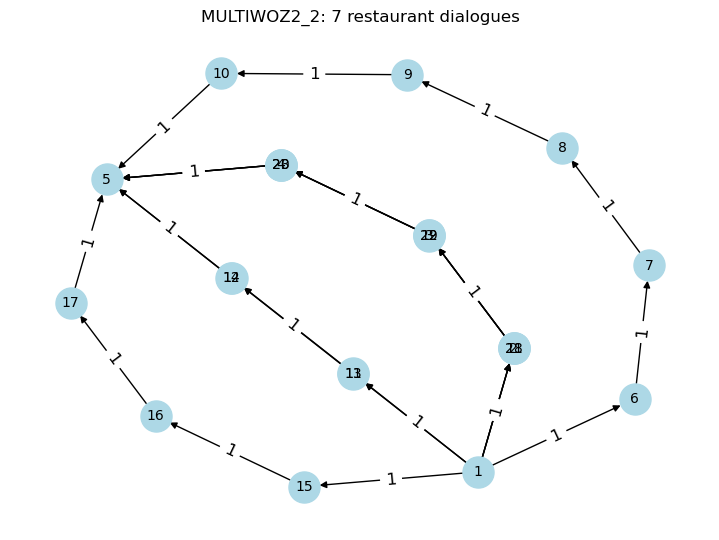

In [28]:
graph.visualise_short("MULTIWOZ2_2: 7 restaurant dialogues")

In [29]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'options_price_range',
  'is_start': False,
  'utterances': ['There are a number of options for Indian restaurants in the centre of town. What price range would you like?']},
 {'id': 3,
  'label': 'recommend_restaurant',
  'is_start': False,
  'utterances': ['I was able to find three options in your price range, may I recommend The Gandhi?']},
 {'id': 4,
  'label': 'booking_confirmation_with_ref',
  'is_start': False,
  'utterances': ['I was able to book that for you. They will be reserve your table for 15 minutes. Your reference number is 6EQ61SD9 . Is there anything more I can help with?']},
 {'id': 5,
  'label': 'end',
  'is_start': False,
  'utterances': ['Thank you for calling, enjoy!',
   "You're welcome. Thank you for contacting Cambridge TownInfo centre, and have a great day.",
   'Thank you. Have a nice day.',
   'Thank you for using our service. Have a gre

In [ ]:
graph.graph_dict['edges']

#### 8 restaurant dialogues

In [ ]:
test_data = [Dialogue.from_list(c) for c in new_data[:8]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

In [ ]:
graph.visualise_short("MULTIWOZ2_2: 8 restaurant dialogues")

## META_WOZ

In [148]:
dataset = load_dataset('microsoft/meta_woz', trust_remote_code=True)

### BOOKING_FLIGHT

In [149]:
new_data=[]
for d in [el['turns'] for el in dataset['test'] if el['domain'] == 'BOOKING_FLIGHT']:
    exist = [[{"text":a,"participant":"assistant"},{"text":u,"participant":"user"}] for a,u in zip(d[0:-1:2],d[1::2])]+[[{"text":d[-1],"participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])

In [37]:
len(new_data)

554

#### 2 dialogues

In [10]:
new_data[:2]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [150]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'can_help_book_flight', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?']}, {'id': 3, 'label': 'ask_leave_time', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 4, 'label': 'confirm_flight_details', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 5, 'label': 'finalize_booking', 'is_start': False, 'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']}, {'id': 6, 'label': 'cancel_booking', 'is_start': False, 'utterances': ['Flight booking has been cancelled. We hope to see you again soon.']}, {'id': 7, 'label': 'sure', 'is_start': False, 'utterances': ['Sure']}, {'id': 8, 'label': 'offer

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']}, {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]}, {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']}, {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']}, {'source': 5, 'target': 6, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 1, 'target': 7, 'utterances': ['I need some help with some information please']}, {'source': 7, 'target': 8, 'utterances': ['how do I get a flight to Greece?']}, {'source': 8, 'target': 9, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 9, 'target': 10, 'utterances': ['Okay, that seems pretty easy']}, {'source': 10, 'target': 11, 'utterances': ['Nope, thanks for your help!']}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello ho

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='5', metadata={'id': 5}, page_content='Great'), 0.9999999999990536), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.3456119720705767), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.21399920743548617), (Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.15012144383237513), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096091060222937), (Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), -0.0019150513883670062)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)


True

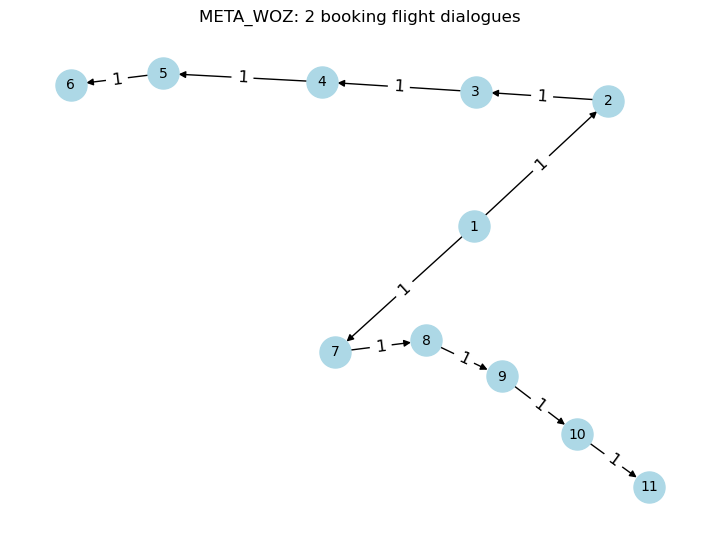

In [151]:
graph.visualise_short("META_WOZ: 2 booking flight dialogues")

In [152]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'can_help_book_flight',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?']},
 {'id': 3,
  'label': 'ask_leave_time',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 4,
  'label': 'confirm_flight_details',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']},
 {'id': 5,
  'label': 'finalize_booking',
  'is_start': False,
  'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']},
 {'id': 6,
  'label': 'cancel_booking',
  'is_start': False,
  'utterances': ['Flight booking has been cancelled. We hope to see you again soon.']},
 {'id': 7, 'label': 'sure', 'is_start': False, 'utterances': ['Sure']},
 

In [153]:
graph.graph_dict['edges']

[{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]},
 {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']},
 {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']},
 {'source': 5,
  'target': 6,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 1,
  'target': 7,
  'utterances': ['I need some help with some information please']},
 {'source': 7,
  'target': 8,
  'utterances': ['how do I get a flight to Greece?']},
 {'source': 8,
  'target': 9,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 9, 'target': 10, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 10, 'target': 11, 'utterances': ['Nope, thanks for your help!']}]

#### <span style="color:green">2 dialogues graph is correct</span>

#### 3 dialogues

In [18]:
new_data[:3]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [155]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_book_flight', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?', 'I can book a flight for you', 'i can book you a flight there to save you some time']}, {'id': 3, 'label': 'ask_leave_time', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 4, 'label': 'confirm_flight_details_ask_date', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 5, 'label': 'confirm_booking_info', 'is_start': False, 'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']}, {'id': 6, 'label': 'cancel_booking', 'is_start': False, 'utterances': ['Flight booking has been cancelled. We hope to see you again soon.']}, 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']}, {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]}, {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']}, {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']}, {'source': 5, 'target': 6, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 1, 'target': 7, 'utterances': ['I need some help with some information please']}, {'source': 2, 'target': 8, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 7, 'target': 2, 'utterances': ['how do I get a flight to Greece?']}, {'source': 8, 'target': 9, 'utterances': ['Okay, that seems pretty easy']}, {'source': 9, 'target': 10, 'utterances': ['Nope, thanks for your help!']}, {'source': 1, 'target': 11, 'utterances': ['I need some travel information please.'

False

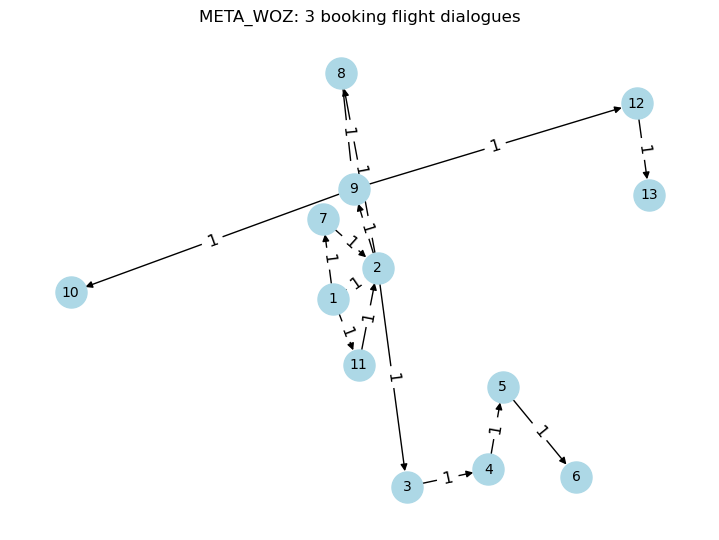

In [156]:
graph.visualise_short("META_WOZ: 3 booking flight dialogues")

In [158]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'offer_book_flight',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?',
   'I can book a flight for you',
   'i can book you a flight there to save you some time']},
 {'id': 3,
  'label': 'ask_leave_time',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 4,
  'label': 'confirm_flight_details_ask_date',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']},
 {'id': 5,
  'label': 'confirm_booking_info',
  'is_start': False,
  'utterances': ['Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.']},
 {'id': 6,
  'label': 'cancel_booking',
  'is_start': False,
  'utterances': ['Flight booking has been cancelled. We hop

In [159]:
graph.graph_dict['edges']

[{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 2, 'target': 3, 'utterances': ["Yes that's where I want to go."]},
 {'source': 3, 'target': 4, 'utterances': ['I want to leave from Dallas.']},
 {'source': 4, 'target': 5, 'utterances': ['I want to leave by next Friday.']},
 {'source': 5,
  'target': 6,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 1,
  'target': 7,
  'utterances': ['I need some help with some information please']},
 {'source': 2,
  'target': 8,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 7,
  'target': 2,
  'utterances': ['how do I get a flight to Greece?']},
 {'source': 8, 'target': 9, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 9, 'target': 10, 'utterances': ['Nope, thanks for your help!']},
 {'source': 1,
  'target': 11,
  'utterances': ['I need some travel informati

#### <span style="color:green">3 dialogues graph is correct</span>

#### 4 dialogues

In [36]:
new_data[:4]

[[{'text': 'Hello how may I help you?', 'participant': 'assistant'},
  {'text': 'Hello, I want to book a flight.', 'participant': 'user'},
  {'text': 'Can I help you book a flight to greece?',
   'participant': 'assistant'},
  {'text': "Yes that's where I want to go.", 'participant': 'user'},
  {'text': 'Perfect, and when would you like to leave?',
   'participant': 'assistant'},
  {'text': 'I want to leave from Dallas.', 'participant': 'user'},
  {'text': 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?',
   'participant': 'assistant'},
  {'text': 'I want to leave by next Friday.', 'participant': 'user'},
  {'text': 'Alright booking your flight between now and next friday. You will be alerted when your flight is book and vased on the lowest available price.',
   'participant': 'assistant'},
  {'text': "Wait please don't do that, I was only curious. I don't actually want to book a flight",
   'participant': 'user'},
  {'text': 'F

In [160]:
test_data = [Dialogue.from_list(c) for c in new_data[:4]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_help_or_gather_info', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?', 'Sure', 'sure what do you wanna know?', 'Where would you like to go?']}, {'id': 3, 'label': 'offer_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time']}, {'id': 4, 'label': 'ask_when_leave', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?']}, {'id': 5, 'label': 'ask_preferences', 'is_start': False, 'utterances': ['Do you prefer a specific airline?', 'Is this for a round trip?']}, {'id': 6, 'label': 'confirm_flight_and_ask_date', 'is_start': False, 'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 7, 'label': 'provide_flight_info', 'is_start': False, 'utterances': ['You

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 2, 'target': 4, 'utterances': ["Yes that's where I want to go."]}, {'source': 4, 'target': 6, 'utterances': ['I want to leave from Dallas.']}, {'source': 6, 'target': 13, 'utterances': ['I want to leave by next Friday.']}, {'source': 13, 'target': 14, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 3, 'target': 7, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 7, 'target': 10, 'utterances': ['Okay, that seems pretty easy']}, {'source': 10, 'target': 10, 'utterances': ['Nope, thanks for your help!']}, {'source': 2, 'target': 3, 'utterances': ['how do I get a flight to Greece?', 'I need to know how I would go about getting a flight to Greece when I need to go.']}, {'source': 3, 'target': 10, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 

False

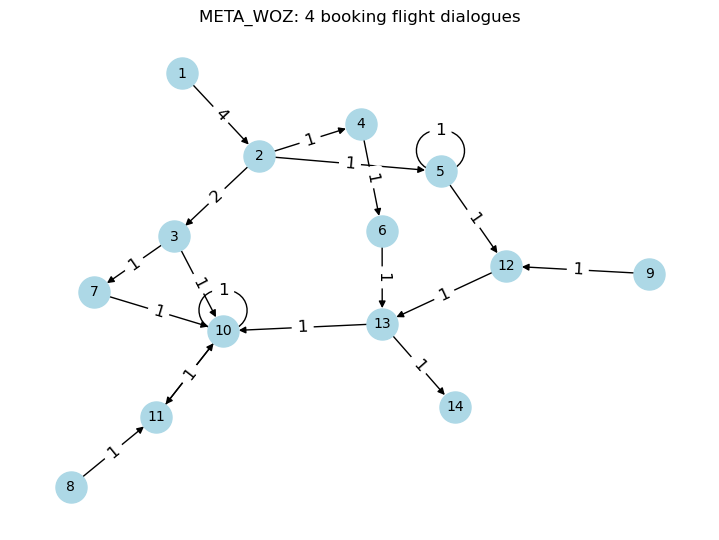

In [164]:
graph.visualise_short("META_WOZ: 4 booking flight dialogues")

In [165]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'offer_help_or_gather_info',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?',
   'Sure',
   'sure what do you wanna know?',
   'Where would you like to go?']},
 {'id': 3,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time']},
 {'id': 4,
  'label': 'ask_when_leave',
  'is_start': False,
  'utterances': ['Perfect, and when would you like to leave?']},
 {'id': 5,
  'label': 'ask_preferences',
  'is_start': False,
  'utterances': ['Do you prefer a specific airline?',
   'Is this for a round trip?']},
 {'id': 6,
  'label': 'confirm_flight_and_ask_date',
  'is_start': False,
  'utterances': ['Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']},
 {'id': 7,
  'label': 'provide_flight_info

In [166]:
graph.graph_dict['edges']

[{'source': 2, 'target': 4, 'utterances': ["Yes that's where I want to go."]},
 {'source': 4, 'target': 6, 'utterances': ['I want to leave from Dallas.']},
 {'source': 6,
  'target': 13,
  'utterances': ['I want to leave by next Friday.']},
 {'source': 13,
  'target': 14,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 3,
  'target': 7,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 7, 'target': 10, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 10, 'target': 10, 'utterances': ['Nope, thanks for your help!']},
 {'source': 2,
  'target': 3,
  'utterances': ['how do I get a flight to Greece?',
   'I need to know how I would go about getting a flight to Greece when I need to go.']},
 {'source': 3,
  'target': 10,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},

In [167]:
test_data = [Dialogue.from_list(c) for c in new_data[:5]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_help_information', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'Sure thing. And what can I help you with today?']}, {'id': 3, 'label': 'offer_book_flight', 'is_start': False, 'utterances': ['Can I help you book a flight to greece?', 'I can book a flight for you', 'i can book you a flight there to save you some time']}, {'id': 4, 'label': 'ask_destination', 'is_start': False, 'utterances': ['Where would you like to go?']}, {'id': 5, 'label': 'ask_departure_details', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?', 'Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?']}, {'id': 6, 'label': 'provide_flight_information', 'is_start': False, 'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 1, 'target': 3, 'utterances': ['Hello, I want to book a flight.']}, {'source': 3, 'target': 5, 'utterances': ["Yes that's where I want to go."]}, {'source': 5, 'target': 5, 'utterances': ['I want to leave from Dallas.']}, {'source': 5, 'target': 7, 'utterances': ['I want to leave by next Friday.']}, {'source': 7, 'target': 8, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 3, 'target': 6, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 2, 'target': 3, 'utterances': ['how do I get a flight to Greece?', 'I need to know how I would go about getting a flight to Greece when I need to go.']}, {'source': 3, 'target': None, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 1, 'target': 4, 'utterances': ['I need to book a flight real quick']}, {'sou

AttributeError: 'NoneType' object has no attribute 'nodes'

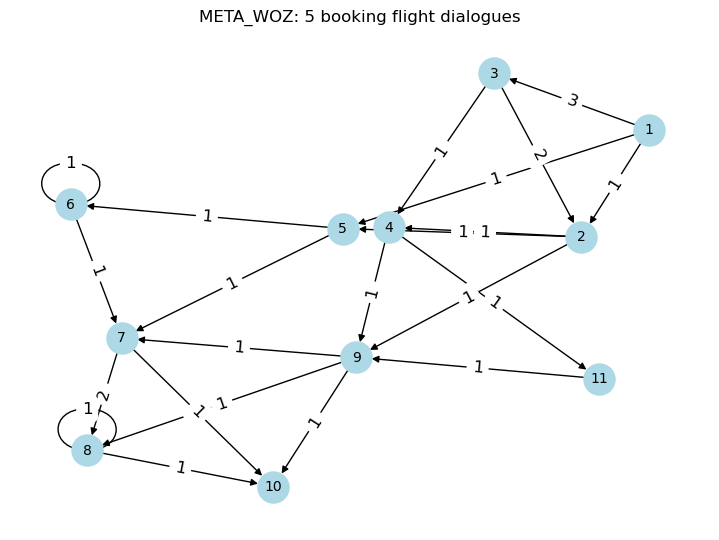

In [130]:
graph.visualise_short("META_WOZ: 5 booking flight dialogues")

In [132]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['Can I help you book a flight to greece?',
   'I can book a flight for you',
   'i can book you a flight there to save you some time']},
 {'id': 3,
  'label': 'generic_confirmation',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'Sure thing. And what can I help you with today?']},
 {'id': 4,
  'label': 'provide_booking_info',
  'is_start': False,
  'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to',
   "You will need to first make some research for the airport you are going to take. Then, you'll want to find out prices and seating arrangements. Finally, pick your destination and pay for the ticket, then wait at the terminal."]},
 {'id': 5,
  'label': 'ask_flight_details',
  'is_start': False,
  'utterances': 

In [131]:
graph.graph_dict['edges']

[{'source': 1, 'target': 2, 'utterances': ['Hello, I want to book a flight.']},
 {'source': 2, 'target': 5, 'utterances': ["Yes that's where I want to go."]},
 {'source': 5, 'target': 7, 'utterances': ['I want to leave from Dallas.']},
 {'source': 8,
  'target': 8,
  'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]},
 {'source': 2,
  'target': 4,
  'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]},
 {'source': 4, 'target': 9, 'utterances': ['Okay, that seems pretty easy']},
 {'source': 9, 'target': 10, 'utterances': ['Nope, thanks for your help!']},
 {'source': 2,
  'target': 9,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},
 {'source': 3,
  'target': 2,
  'utterances': ['how do I get a flight to Greece?',
   'I need to know how I would go about getting a flight to Greece when I need to go.']},
 {'source

In [168]:
test_data = [Dialogue.from_list(c) for c in new_data[:6]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_help', 'is_start': False, 'utterances': ['Sure', 'Can I help you book a flight to greece?', 'sure what do you wanna know?', 'Where would you like to go?', 'Sure thing. And what can I help you with today?', 'Certainly, where would you like to go?']}, {'id': 3, 'label': 'offer_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time', 'Great. Can I book a flight to Greece for you today?']}, {'id': 4, 'label': 'ask_departure_details', 'is_start': False, 'utterances': ['Perfect, and when would you like to leave?', 'When would you like to leave?', 'I want to leave by next Friday.', 'I need to get to anywhere in western Europe as soon as I can but no later than next Tuesday.', 'I want to leave from Dallas.']}, {'id': 5, 'label': 'provide_flight_options', 'is_start': False, 'utterances': 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='Perfect, and when would you like to leave?'), 0.15744547028550726), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096082630853235), (Document(id='1', metadata={'id': 1}, page_content='Can I help you book a flight to greece?'), 0.08380725521054644), (Document(id='5', metadata={'id': 5}, page_content='Flight booking has been cancelled. We hope to see you again soon.'), 0.06941022893401316), (Document(id='3', metadata={'id': 3}, page_content='Alright, i have your flight leaving from dallas and landing in athens. When would you like to fly there?'), 0.022034305222069506), (Document(id='4', metadata={'id': 4}, page_content='Alright booking your flight between now and next friday. You will be alerted when your flight 

RESULT:  {'edges': [{'source': 2, 'target': 4, 'utterances': ["Yes that's where I want to go."]}, {'source': 4, 'target': 5, 'utterances': ['I want to leave from Dallas.']}, {'source': 5, 'target': 5, 'utterances': ['I want to leave by next Friday.']}, {'source': 5, 'target': 7, 'utterances': ["Wait please don't do that, I was only curious. I don't actually want to book a flight"]}, {'source': 3, 'target': 8, 'utterances': ["I'm not really ready to book. I was just curious how I would get a flight there"]}, {'source': 9, 'target': 11, 'utterances': ['Nope, thanks for your help!']}, {'source': 3, 'target': 9, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 8, 'target': 10, 'utterances': ['That is a great price. Thanks for the information.']}, {'source': 9, 'target': 8, 'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']}, {'source': 2, 'target'

AttributeError: 'NoneType' object has no attribute 'nodes'

In [ ]:
graph.visualise_short("META_WOZ: 6 booking flight dialogues")

In [169]:
test_data = [Dialogue.from_list(c) for c in new_data[1:3]+new_data[6:9:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'offer_help', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'You rather want me to book a flight for you to Greece?', 'Sure, how can I help']}, {'id': 3, 'label': 'offer_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time', 'Do you want me to book you a flight or do you want info on how to book a flight']}, {'id': 4, 'label': 'provide_booking_info', 'is_start': False, 'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to', 'Check airports to have flight to Greece and you can check schedule of the flight and price.', 'Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website']}, {'id': 5, 'label': 'provide_flight_cost', 'is_star

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.723295571401247), (Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), 0.5478733915220533), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.411750324040418), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.24858364691807044), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.07874154119432508), (Document(id='5', metadata={'id': 5}, page_content='Great'), -0.0013846754467057298)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)
/data/home/peshkichev/

RESULT:  {'edges': [{'source': 3, 'target': 6, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 5, 'target': 7, 'utterances': ['That is a great price. Thanks for the information.']}, {'source': 6, 'target': 5, 'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']}, {'source': 2, 'target': 4, 'utterances': ['no dont need to book a flight just looking for some general information.']}, {'source': 4, 'target': 6, 'utterances': ['Okay, that seems pretty easy', 'alright thanks for this info']}, {'source': 6, 'target': 7, 'utterances': ['Nope, thanks for your help!', 'no that is all i need for my research at the moment']}, {'source': 7, 'target': 7, 'utterances': ['bye']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.', 'need info about booking a flight to a place such 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='1', metadata={'id': 1}, page_content='Sure, how can I help'), 0.22115220197736107), (Document(id='5', metadata={'id': 5}, page_content='No problem, anything else'), 0.1941040404770097), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.14096091060222937), (Document(id='4', metadata={'id': 4}, page_content='It could close to 1000 cost'), 0.08375415018142274), (Document(id='2', metadata={'id': 2}, page_content='Do you want me to book you a flight or do you want info on how to book a flight'), -0.001384506859311685), (Document(id='3', metadata={'id': 3}, page_content='Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website'), -0.022209349002241474)]
  docs = self.assistant_store.similarity_

False

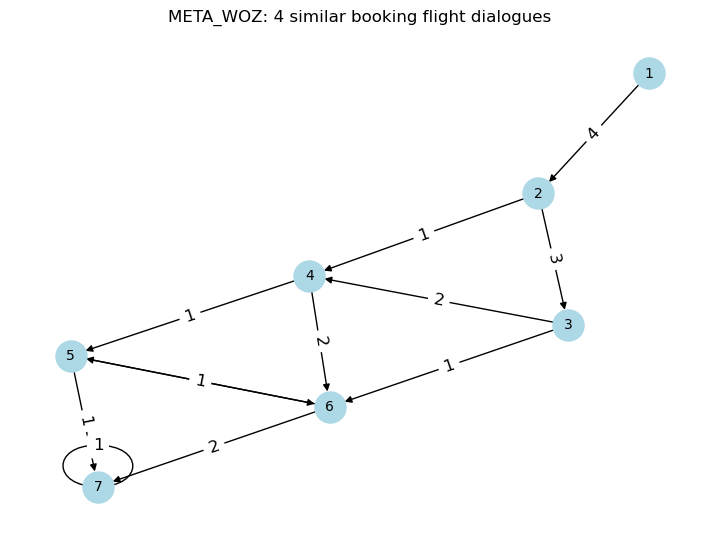

In [170]:
graph.visualise_short("META_WOZ: 4 similar booking flight dialogues")

In [171]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'offer_help',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'You rather want me to book a flight for you to Greece?',
   'Sure, how can I help']},
 {'id': 3,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time',
   'Do you want me to book you a flight or do you want info on how to book a flight']},
 {'id': 4,
  'label': 'provide_booking_info',
  'is_start': False,
  'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to',
   'Check airports to have flight to Greece and you can check schedule of the flight and price.',
   'Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the airlines own website']},
 {'id': 5,
  'label'

In [172]:
graph.graph_dict['edges']

[{'source': 3,
  'target': 6,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},
 {'source': 5,
  'target': 7,
  'utterances': ['That is a great price. Thanks for the information.']},
 {'source': 6,
  'target': 5,
  'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']},
 {'source': 2,
  'target': 4,
  'utterances': ['no dont need to book a flight just looking for some general information.']},
 {'source': 4,
  'target': 6,
  'utterances': ['Okay, that seems pretty easy',
   'alright thanks for this info']},
 {'source': 6,
  'target': 7,
  'utterances': ['Nope, thanks for your help!',
   'no that is all i need for my research at the moment']},
 {'source': 7, 'target': 7, 'utterances': ['bye']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.',
   'need info about booki

In [173]:
test_data = [Dialogue.from_list(c) for c in new_data[1:3]+new_data[6:9:2]+[new_data[11]]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello how may I help you?']}, {'id': 2, 'label': 'ask_help', 'is_start': False, 'utterances': ['Sure', 'sure what do you wanna know?', 'Sure, how can I help', 'what can I do for you']}, {'id': 3, 'label': 'offer_booking', 'is_start': False, 'utterances': ['I can book a flight for you', 'i can book you a flight there to save you some time', 'I can do that for you. When do you want to leave?', 'Do you want me to book you a flight or do you want info on how to book a flight', 'You rather want me to book a flight for you to Greece?']}, {'id': 4, 'label': 'provide_flight_info', 'is_start': False, 'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to', 'Check airports to have flight to Greece and you can check schedule of the flight and price.', 'Okay there is the airport as one option. Secondly, there are websites like travelocity, expedia, or the 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='2', metadata={'id': 2}, page_content='I can book a flight for you'), 0.723295571401247), (Document(id='3', metadata={'id': 3}, page_content='You can check airports has a schedule flight to Greece and there you can book a flight if you want to'), 0.5478733915220533), (Document(id='0', metadata={'id': 0}, page_content='Hello how may I help you?'), 0.411750324040418), (Document(id='4', metadata={'id': 4}, page_content='Anything else?'), 0.24858364691807044), (Document(id='1', metadata={'id': 1}, page_content='Sure'), 0.07874154119432508), (Document(id='5', metadata={'id': 5}, page_content='Great'), -0.0013846754467057298)]
  docs = self.assistant_store.similarity_search_with_relevance_scores(utterance, k=self.assistant_size, score_threshold=env_settings.EMBEDDER_TYPO)
/data/home/peshkichev/

RESULT:  {'edges': [{'source': 3, 'target': 5, 'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]}, {'source': 5, 'target': 7, 'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']}, {'source': 7, 'target': 6, 'utterances': ['That is a great price. Thanks for the information.']}, {'source': 1, 'target': 3, 'utterances': ['need info about booking a flight to a place such as Greece']}, {'source': 6, 'target': 6, 'utterances': ['bye']}, {'source': 4, 'target': 7, 'utterances': ['How much do flights to Greece usually cost?']}, {'source': 7, 'target': 5, 'utterances': ['Okay. Thanks for your helpful information!']}, {'source': 1, 'target': 2, 'utterances': ['I need some help with some information please', 'I need some travel information please.', 'Can you help me get information about a flights?', 'i have a request']}, {'source': 2, 'target': 3, 'utterances': ['how 

False

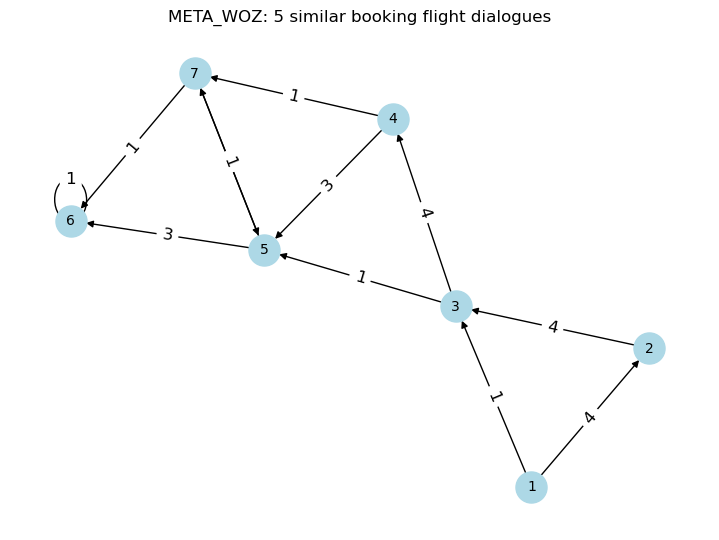

In [174]:
graph.visualise_short("META_WOZ: 5 similar booking flight dialogues")

In [175]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello how may I help you?']},
 {'id': 2,
  'label': 'ask_help',
  'is_start': False,
  'utterances': ['Sure',
   'sure what do you wanna know?',
   'Sure, how can I help',
   'what can I do for you']},
 {'id': 3,
  'label': 'offer_booking',
  'is_start': False,
  'utterances': ['I can book a flight for you',
   'i can book you a flight there to save you some time',
   'I can do that for you. When do you want to leave?',
   'Do you want me to book you a flight or do you want info on how to book a flight',
   'You rather want me to book a flight for you to Greece?']},
 {'id': 4,
  'label': 'provide_flight_info',
  'is_start': False,
  'utterances': ['You can check airports has a schedule flight to Greece and there you can book a flight if you want to',
   'Check airports to have flight to Greece and you can check schedule of the flight and price.',
   'Okay there is the airport as one option. Secondly, there are website

In [176]:
graph.graph_dict['edges']

[{'source': 3,
  'target': 5,
  'utterances': ["Well that's good to hear, but I don't want to book a flight today. I just want to know what I need to do."]},
 {'source': 5,
  'target': 7,
  'utterances': ['Just for my own information, can you tell me how much a flight to Greece costs right now?']},
 {'source': 7,
  'target': 6,
  'utterances': ['That is a great price. Thanks for the information.']},
 {'source': 1,
  'target': 3,
  'utterances': ['need info about booking a flight to a place such as Greece']},
 {'source': 6, 'target': 6, 'utterances': ['bye']},
 {'source': 4,
  'target': 7,
  'utterances': ['How much do flights to Greece usually cost?']},
 {'source': 7,
  'target': 5,
  'utterances': ['Okay. Thanks for your helpful information!']},
 {'source': 1,
  'target': 2,
  'utterances': ['I need some help with some information please',
   'I need some travel information please.',
   'Can you help me get information about a flights?',
   'i have a request']},
 {'source': 2,
  'targ

## SCHEMA Dataset

In [177]:
dataset = load_dataset("GEM/schema_guided_dialog", trust_remote_code=True)

In [144]:
dataset

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 164982
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 10000
    })
    challenge_train_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'context', 'dialog_id', 'service', 'turn_id', 'prompt', 'target', 'references', 'linearized_input'],
        num_rows: 500
    })
    challenge_validation_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'dialog_acts', 'conte

In [184]:
len([d for d in dataset['test'] if d['service'] == 'RentalCars_3'])

932

In [193]:
new_data=[]
for d in [el for el in dataset['test'] if el['service'] == 'RentalCars_3']:
    exist = [[{'text':"Hello! How can I help you?", "participant":"assistant"}]] + [[{"text":u,"participant":"user"},{"text":a,"participant":"assistant"},] for u,a in zip(d['context'][0:-1:2],d['context'][1::2])] + [[{'text':d['prompt'], "participant":"user"}, {'text':d['target'], "participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])

In [203]:
new_data[:1]

[[{'text': 'Hello! How can I help you?', 'participant': 'assistant'},
  {'text': "I'm having a friend visit and we want some fun attractions to go to, maybe a museum. Can you find one for me?",
   'participant': 'user'},
  {'text': 'In which city should I search in?', 'participant': 'assistant'},
  {'text': 'Please look for attractions in London, UK.',
   'participant': 'user'},
  {'text': 'I suggest a museum called Apsley House.',
   'participant': 'assistant'},
  {'text': 'Is there anything else? Preferably something child-friendly.',
   'participant': 'user'},
  {'text': 'I suggest a museum called BODY WORLDS London.',
   'participant': 'assistant'},
  {'text': 'Where can I contact them?', 'participant': 'user'},
  {'text': 'You can contact them at 330 223 3233.',
   'participant': 'assistant'},
  {'text': 'Is there a cost to enter the museum?', 'participant': 'user'},
  {'text': 'No, it is free to enter.', 'participant': 'assistant'},
  {'text': "That's great. Can you also find me 

In [204]:
test_data = [Dialogue.from_list(c) for c in new_data[:1]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_city', 'is_start': False, 'utterances': ['In which city should I search in?']}, {'id': 3, 'label': 'suggest_museum1', 'is_start': False, 'utterances': ['I suggest a museum called Apsley House.']}, {'id': 4, 'label': 'suggest_museum2', 'is_start': False, 'utterances': ['I suggest a museum called BODY WORLDS London.']}, {'id': 5, 'label': 'provide_contact', 'is_start': False, 'utterances': ['You can contact them at 330 223 3233.']}, {'id': 6, 'label': 'provide_cost_info', 'is_start': False, 'utterances': ['No, it is free to enter.']}, {'id': 7, 'label': 'ask_return_date', 'is_start': False, 'utterances': ['When do you want to return the car?']}, {'id': 8, 'label': 'ask_pickup_location', 'is_start': False, 'utterances': ['Are you planning to pick it up from London?']}, {'id': 9, 'label': 'suggest_car', 'is_start': False, 'utterances': ['I suggest a Sedan 

True

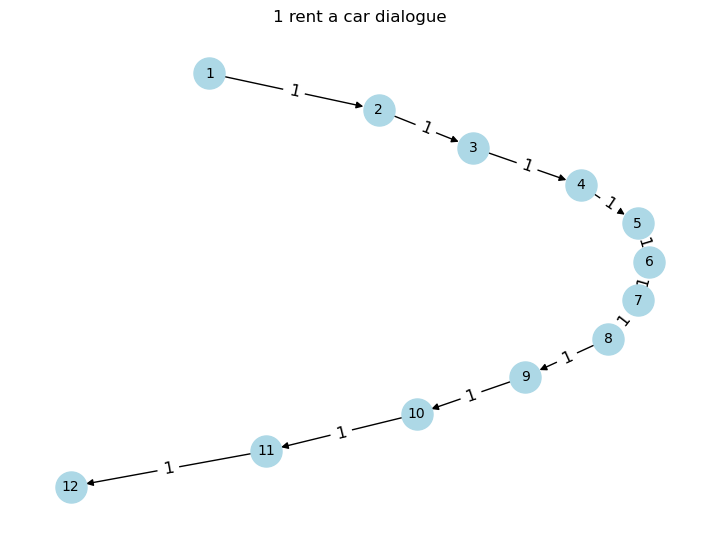

In [205]:
graph.visualise_short("1 rent a car dialogue")

In [209]:
new_data[:2]

[[{'text': 'Hello! How can I help you?', 'participant': 'assistant'},
  {'text': "I'm having a friend visit and we want some fun attractions to go to, maybe a museum. Can you find one for me?",
   'participant': 'user'},
  {'text': 'In which city should I search in?', 'participant': 'assistant'},
  {'text': 'Please look for attractions in London, UK.',
   'participant': 'user'},
  {'text': 'I suggest a museum called Apsley House.',
   'participant': 'assistant'},
  {'text': 'Is there anything else? Preferably something child-friendly.',
   'participant': 'user'},
  {'text': 'I suggest a museum called BODY WORLDS London.',
   'participant': 'assistant'},
  {'text': 'Where can I contact them?', 'participant': 'user'},
  {'text': 'You can contact them at 330 223 3233.',
   'participant': 'assistant'},
  {'text': 'Is there a cost to enter the museum?', 'participant': 'user'},
  {'text': 'No, it is free to enter.', 'participant': 'assistant'},
  {'text': "That's great. Can you also find me 

In [213]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_initial_info', 'is_start': False, 'utterances': ['In which city should I search in?', 'Where are you travelling? What date and time would you like to leave?Ho']}, {'id': 3, 'label': 'ask_departure', 'is_start': False, 'utterances': ['Where are you departing from?']}, {'id': 4, 'label': 'suggest_museum', 'is_start': False, 'utterances': ['I suggest a museum called Apsley House.', 'I suggest a museum called BODY WORLDS London.']}, {'id': 5, 'label': 'provide_contact', 'is_start': False, 'utterances': ['You can contact them at 330 223 3233.']}, {'id': 6, 'label': 'provide_entry_cost', 'is_start': False, 'utterances': ['No, it is free to enter.']}, {'id': 7, 'label': 'ask_return_time', 'is_start': False, 'utterances': ['When do you want to return the car?', 'When will you return it?']}, {'id': 8, 'label': 'ask_pickup_location', 'is_start': False, 'utteranc

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='10', metadata={'id': 10}, page_content="So you'd like to pick up a Sedan from Heathrow International Airport at 11 am from March 7th to March 10th. Is this correct?"), 0.45055994293937085), (Document(id='6', metadata={'id': 6}, page_content='When do you want to return the car?'), 0.3932874755817357), (Document(id='9', metadata={'id': 9}, page_content='Would you like any added insurance?'), 0.3502575241539929), (Document(id='7', metadata={'id': 7}, page_content='Are you planning to pick it up from London?'), 0.3011655493580797), (Document(id='11', metadata={'id': 11}, page_content='Your rental has been booked, and you will pay $36.00 per day.'), 0.27543953449551517), (Document(id='5', metadata={'id': 5}, page_content='No, it is free to enter.'), 0.24719659413357697), (Document(id='8', met

RESULT:  {'edges': [{'source': 2, 'target': 4, 'utterances': ['Please look for attractions in London, UK.']}, {'source': 4, 'target': 4, 'utterances': ['Is there anything else? Preferably something child-friendly.']}, {'source': 4, 'target': 5, 'utterances': ['Where can I contact them?']}, {'source': 5, 'target': 6, 'utterances': ['Is there a cost to enter the museum?']}, {'source': 6, 'target': 7, 'utterances': ["That's great. Can you also find me a rental car? I'd like to pick it up by morning 11 and I need it next Thursday."]}, {'source': 7, 'target': 8, 'utterances': ['I will be needing the car until the 10th of March.']}, {'source': 8, 'target': 9, 'utterances': ['Yes, London is where I want to pick it up.']}, {'source': 9, 'target': 10, 'utterances': ['That works for me, please reserve the rental.']}, {'source': 10, 'target': 11, 'utterances': ["I won't be needing any, no."]}, {'source': 11, 'target': 12, 'utterances': ['That works for me. How much is the car per day?']}, {'sourc

False

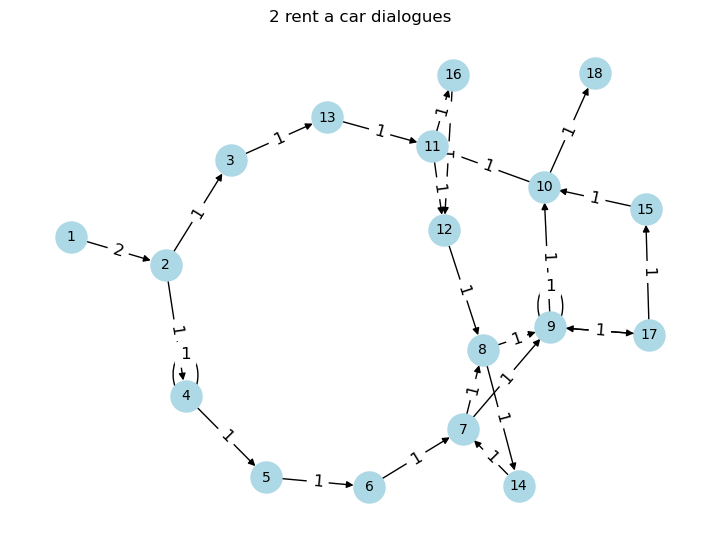

In [214]:
graph.visualise_short("2 rent a car dialogues")

In [216]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_initial_info',
  'is_start': False,
  'utterances': ['In which city should I search in?',
   'Where are you travelling? What date and time would you like to leave?Ho']},
 {'id': 3,
  'label': 'ask_departure',
  'is_start': False,
  'utterances': ['Where are you departing from?']},
 {'id': 4,
  'label': 'suggest_museum',
  'is_start': False,
  'utterances': ['I suggest a museum called Apsley House.',
   'I suggest a museum called BODY WORLDS London.']},
 {'id': 5,
  'label': 'provide_contact',
  'is_start': False,
  'utterances': ['You can contact them at 330 223 3233.']},
 {'id': 6,
  'label': 'provide_entry_cost',
  'is_start': False,
  'utterances': ['No, it is free to enter.']},
 {'id': 7,
  'label': 'ask_return_time',
  'is_start': False,
  'utterances': ['When do you want to return the car?',
   'When will you return it?']},
 {'id': 8,
  'label': 'ask_pick

In [217]:
graph.graph_dict['edges']

[{'source': 2,
  'target': 4,
  'utterances': ['Please look for attractions in London, UK.']},
 {'source': 4,
  'target': 4,
  'utterances': ['Is there anything else? Preferably something child-friendly.']},
 {'source': 4, 'target': 5, 'utterances': ['Where can I contact them?']},
 {'source': 5,
  'target': 6,
  'utterances': ['Is there a cost to enter the museum?']},
 {'source': 6,
  'target': 7,
  'utterances': ["That's great. Can you also find me a rental car? I'd like to pick it up by morning 11 and I need it next Thursday."]},
 {'source': 7,
  'target': 8,
  'utterances': ['I will be needing the car until the 10th of March.']},
 {'source': 8,
  'target': 9,
  'utterances': ['Yes, London is where I want to pick it up.']},
 {'source': 9,
  'target': 10,
  'utterances': ['That works for me, please reserve the rental.']},
 {'source': 10, 'target': 11, 'utterances': ["I won't be needing any, no."]},
 {'source': 11,
  'target': 12,
  'utterances': ['That works for me. How much is the ca

In [220]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_travel_details', 'is_start': False, 'utterances': ['In which city should I search in?', 'Where are you travelling? What date and time would you like to leave?Ho', 'What date do you want to leave', 'What time do you want to leave?', 'Where are you departing from?']}, {'id': 3, 'label': 'suggest_museum', 'is_start': False, 'utterances': ['I suggest a museum called Apsley House.', 'I suggest a museum called BODY WORLDS London.']}, {'id': 4, 'label': 'confirm_tickets', 'is_start': False, 'utterances': ['You want 2 tickets to from Long Beach to San Diego on March 7th at 3:15 pm, correct?', 'Confirming you want to book 4 bus tickets from los angeles to anaheim, departing at 2:45 pm on March 8th.']}, {'id': 5, 'label': 'trip_changes', 'is_start': False, 'utterances': ['It is a direct trip, but that time is unavailable. How about 3:20 pm, which costs $22.', 't

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='10', metadata={'id': 10}, page_content="So you'd like to pick up a Sedan from Heathrow International Airport at 11 am from March 7th to March 10th. Is this correct?"), 0.45055994293937085), (Document(id='6', metadata={'id': 6}, page_content='When do you want to return the car?'), 0.3932874755817357), (Document(id='9', metadata={'id': 9}, page_content='Would you like any added insurance?'), 0.3502575241539929), (Document(id='7', metadata={'id': 7}, page_content='Are you planning to pick it up from London?'), 0.3011655493580797), (Document(id='11', metadata={'id': 11}, page_content='Your rental has been booked, and you will pay $36.00 per day.'), 0.27543953449551517), (Document(id='5', metadata={'id': 5}, page_content='No, it is free to enter.'), 0.24719659413357697), (Document(id='8', met

RESULT:  {'edges': [{'source': 2, 'target': 3, 'utterances': ['Please look for attractions in London, UK.']}, {'source': 3, 'target': 3, 'utterances': ['Is there anything else? Preferably something child-friendly.']}, {'source': 3, 'target': 9, 'utterances': ['Where can I contact them?']}, {'source': 8, 'target': 10, 'utterances': ['That works for me, please reserve the rental.']}, {'source': 9, 'target': 9, 'utterances': ['Is there a cost to enter the museum?']}, {'source': 9, 'target': 7, 'utterances': ["That's great. Can you also find me a rental car? I'd like to pick it up by morning 11 and I need it next Thursday."]}, {'source': 2, 'target': None, 'utterances': ['I am departing from SD.']}, {'source': 6, 'target': None, 'utterances': ['I also need a rental car there.']}, {'source': 7, 'target': None, 'utterances': ['I will return it on the 14th of this month.']}, {'source': 7, 'target': 7, 'utterances': ['I will be needing the car until the 10th of March.', "I'll pick it up on the

AttributeError: 'NoneType' object has no attribute 'nodes'

In [218]:
test_data = [Dialogue.from_list(c) for c in new_data[:6]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_location', 'is_start': False, 'utterances': ['In which city should I search in?', 'Can you specify which location I should search in?', 'Can you tell me the city where you want me to find the hotel?', 'Where are you travelling? What date and time would you like to leave?', 'Where are you departing from?', 'What location will you pick up the car from?', 'When do you want to pick it up?', 'How long do you want to rent the car, and from which city?']}, {'id': 3, 'label': 'suggest_option', 'is_start': False, 'utterances': ['I suggest a museum called Apsley House.', 'I suggest a museum called BODY WORLDS London.', 'A nice 3 star hotel which you might like is Bei Hotel San Francisco.', 'There are 10 cars available including an SUV Alfa Romeo Stelvio at Sacramento Valley Station.', 'There is a nice Buick Regal Sportback Sedan at Downtown Station.', 'There is 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='10', metadata={'id': 10}, page_content="So you'd like to pick up a Sedan from Heathrow International Airport at 11 am from March 7th to March 10th. Is this correct?"), 0.45055994293937085), (Document(id='6', metadata={'id': 6}, page_content='When do you want to return the car?'), 0.3932874755817357), (Document(id='9', metadata={'id': 9}, page_content='Would you like any added insurance?'), 0.3502575241539929), (Document(id='7', metadata={'id': 7}, page_content='Are you planning to pick it up from London?'), 0.3011655493580797), (Document(id='11', metadata={'id': 11}, page_content='Your rental has been booked, and you will pay $36.00 per day.'), 0.27543953449551517), (Document(id='5', metadata={'id': 5}, page_content='No, it is free to enter.'), 0.24719659413357697), (Document(id='8', met

RESULT:  {'edges': [{'source': 3, 'target': 3, 'utterances': ['Is there anything else? Preferably something child-friendly.']}, {'source': 3, 'target': 4, 'utterances': ['Where can I contact them?']}, {'source': 4, 'target': 5, 'utterances': ['Is there a cost to enter the museum?']}, {'source': 5, 'target': 9, 'utterances': ["That's great. Can you also find me a rental car? I'd like to pick it up by morning 11 and I need it next Thursday."]}, {'source': 7, 'target': 8, 'utterances': ['That works for me. How much is the car per day?']}, {'source': 9, 'target': 9, 'utterances': ['I will be needing the car until the 10th of March.']}, {'source': 2, 'target': 9, 'utterances': ['I am departing from SD.']}, {'source': 5, 'target': 8, 'utterances': ['YEs that would be fine.']}, {'source': 5, 'target': 3, 'utterances': ['What else did you find?']}, {'source': 5, 'target': 6, 'utterances': ['That sounds good.']}, {'source': 8, 'target': None, 'utterances': ['I also need a rental car there.']}, 

/data/home/peshkichev/projects/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/vectors.py:47: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='0', metadata={'id': 0}, page_content='Hello! How can I help you?'), 0.20319646439996186), (Document(id='3', metadata={'id': 3}, page_content='Till when are you going to have the care rented, and when will it be possible for you to pick up the car?'), 0.14671530412311873), (Document(id='1', metadata={'id': 1}, page_content='Can you tell me the city where you want me to find the hotel?'), 0.14005340466009286), (Document(id='2', metadata={'id': 2}, page_content='A nice 3 star hotel which you might like is Bei Hotel San Francisco.'), 0.03809967235005807), (Document(id='4', metadata={'id': 4}, page_content='I have found 4 cars which you might consider, with one of them being a SUV GMC Terrain, which you can pick up at SFO International Airport.'), -0.019878881160680262)]
  docs = self.assista

AttributeError: 'NoneType' object has no attribute 'nodes'

In [ ]:
graph.visualise_short("META_WOZ: 2 rent a car dialogues")

In [ ]:
graph.graph_dict['nodes']

In [ ]:
graph.graph_dict['edges']

## TaskMaster3

In [199]:
dataset = load_dataset("google-research-datasets/taskmaster3", trust_remote_code=True)

In [212]:
dataset['train'][0]

{'conversation_id': 'dlg-bca5ce0a-056f-446e-be94-3ba77b32a84f',
 'vertical': 'Movie Tickets',
 'instructions': 'SCENARIO: In the conversation below, a customer is talking to a booking agent to purchase movie tickets. However, the customer’s turns are missing. The details mentioned (theater names, cities, etc.) do NOT necessarily reflect real life, but you should pretend they are real for the purposes of this exercise.\n\nYOUR TASK: {{LIST *Pretend you are the customer*., Fill in the *missing turns* (in green) so that the conversation makes sense and sounds natural., Make sure you *follow the instructions* provided in parentheses for each turn. (Start typing to make the instructions move outside the box.), Do not copy the wording. *Use your own words*., *Use your normal speaking style* for this scenario but don’t be overly chatty., *Do NOT* call the booking agent by any name including “sir” “madam” etc.}}\n\n{{HIDE movie_1 name.movie No Time To Die}}\n{{HIDE theater_1 name.theater AMC M

In [221]:
new_data=[]
for d in [el for el in dataset['train'] if el['vertical'] == 'Movie Tickets']:
    exist = [{'text':"Hello! How can I help you?", "participant":"assistant"}] + [{"text":u['text'],"participant":u['speaker']} for u in d['utterances']]
    new_data.append(exist)

In [225]:
test_data = [Dialogue.from_list(c) for c in new_data[:1]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_movie_type', 'is_start': False, 'utterances': ['No problem. Is there a particular type of movie you’re looking for?']}, {'id': 3, 'label': 'offer_listings', 'is_start': False, 'utterances': ['Sure. I can help with that. Let me listings at AMC Mercado 24.']}, {'id': 4, 'label': 'confirm_movie_interest', 'is_start': False, 'utterances': ['Oh, sorry about that. So you’re interested in action films at AMC Mountain 16, right?']}, {'id': 5, 'label': 'show_movie_options', 'is_start': False, 'utterances': ['OK. I show one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any of those work?']}, {'id': 6, 'label': 'ask_tickets', 'is_start': False, 'utterances': ['Great. And how many tickets?']}, {'id': 7, 'label': 'confirm_ticket_info', 'is_start': False, 'utterances': ['All right. Let me confirm tha

True

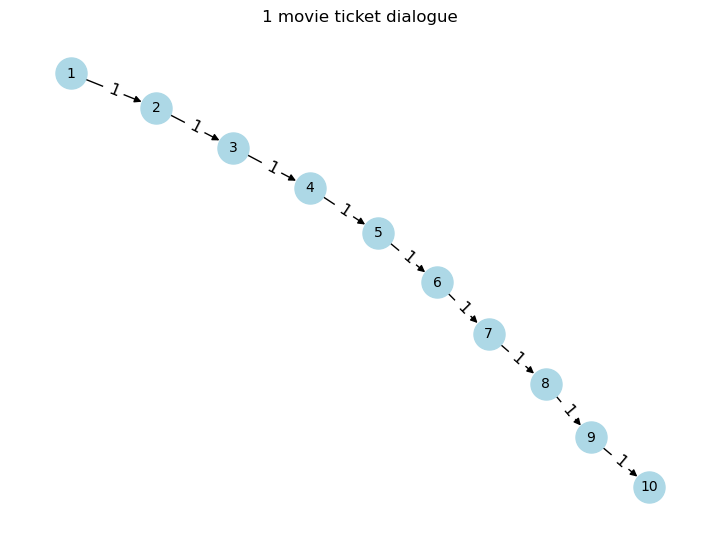

In [226]:
graph.visualise_short("1 movie ticket dialogue")

#### 2 movie tickets dialogues

In [227]:
test_data = [Dialogue.from_list(c) for c in new_data[:2]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_movie_type', 'is_start': False, 'utterances': ['No problem. Is there a particular type of movie you’re looking for?']}, {'id': 3, 'label': 'provide_listing', 'is_start': False, 'utterances': ['Sure. I can help with that. Let me check listings at AMC Mercado 24.', 'Sure. I can help with that. Let me listings at AMC Mercado 24.']}, {'id': 4, 'label': 'confirm_location_action', 'is_start': False, 'utterances': ['Oh, sorry about that. So you’re interested in action films at AMC Mountain 16, right?']}, {'id': 5, 'label': 'provide_movie_showtimes', 'is_start': False, 'utterances': ['OK. I show one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any of those work?', 'OK. I see one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any

False

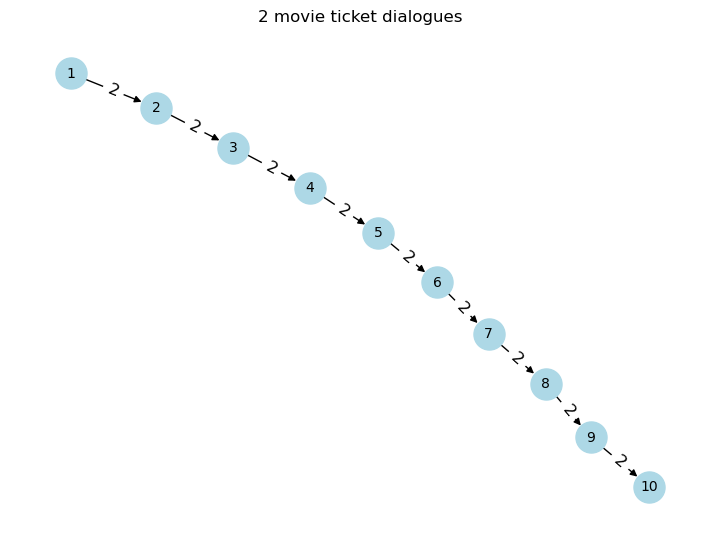

In [228]:
graph.visualise_short("2 movie ticket dialogues")

In [229]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': 'start',
  'is_start': True,
  'utterances': ['Hello! How can I help you?']},
 {'id': 2,
  'label': 'ask_movie_type',
  'is_start': False,
  'utterances': ['No problem. Is there a particular type of movie you’re looking for?']},
 {'id': 3,
  'label': 'provide_listing',
  'is_start': False,
  'utterances': ['Sure. I can help with that. Let me check listings at AMC Mercado 24.',
   'Sure. I can help with that. Let me listings at AMC Mercado 24.']},
 {'id': 4,
  'label': 'confirm_location_action',
  'is_start': False,
  'utterances': ['Oh, sorry about that. So you’re interested in action films at AMC Mountain 16, right?']},
 {'id': 5,
  'label': 'provide_movie_showtimes',
  'is_start': False,
  'utterances': ['OK. I show one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any of those work?',
   'OK. I see one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40p

In [230]:
graph.graph_dict['edges']

[{'source': 1,
  'target': 2,
  'utterances': ['hi....am buying a ticket tonight so we go and see a movie at AMC mountain 16',
   'I am looking for tickets tonight at the AMC Mountain 16']},
 {'source': 2,
  'target': 3,
  'utterances': ['hhhmmmmm not at all. i dont have any in mind for now',
   'Action if possible']},
 {'source': 3,
  'target': 4,
  'utterances': ['sure you can but i want to see the movie at AMC mountain 16',
   'Actually, it is the Mountain 16 that I am looking for']},
 {'source': 4, 'target': 5, 'utterances': ['yeah', 'yes']},
 {'source': 5,
  'target': 6,
  'utterances': ['yeah but 9.10pm will be perfect for me',
   'yes, 9:10 is perfect']},
 {'source': 6,
  'target': 7,
  'utterances': ['myself and two other persons are going to see a movie',
   'Me and my two daughters are going']},
 {'source': 7, 'target': 8, 'utterances': ['yeah', 'yes']},
 {'source': 8, 'target': 9, 'utterances': ['yes you can', 'please, yes']},
 {'source': 9,
  'target': 10,
  'utterances': [

In [233]:
test_data = [Dialogue.from_list(c) for c in new_data[:3]]
graph = graph_generator.invoke(test_data)
all_utterances_present(graph, test_data)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


NODES:  {'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'ask_movie_type', 'is_start': False, 'utterances': ['No problem. Is there a particular type of movie you’re looking for?']}, {'id': 3, 'label': 'confirm_listing', 'is_start': False, 'utterances': ['Sure. I can help with that. Let me check listings at AMC Mercado 24.']}, {'id': 4, 'label': 'confirm_location', 'is_start': False, 'utterances': ['Oh, sorry about that. So you’re interested in action films at AMC Mountain 16, right?']}, {'id': 5, 'label': 'present_movies', 'is_start': False, 'utterances': ['OK. I show one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any of those work?', 'OK. I see one action movie playing at AMC Mountain 16: No Time To Die. Remaining showtimes are 4:30pm, 6:40pm and 9:10pm. Does any of those work?']}, {'id': 6, 'label': 'ask_ticket_quantity', 'is_start': False, '

AttributeError: 'NoneType' object has no attribute 'nodes'

In [ ]:
graph.visualise_short("6 movie ticket dialogues")

In [ ]:
graph.graph_dict['nodes']

In [ ]:
graph.graph_dict['edges']

In [ ]:
dataset = load_dataset("google-research-datasets/taskmaster3", trust_remote_code=True)

In [234]:
dataset = load_dataset("RUCAIBox/Task-Dialogue")

README.md:   0%|          | 0.00/582 [00:00<?, ?B/s]

DataFilesNotFoundError: No (supported) data files found in RUCAIBox/Task-Dialogue